### **Описание проекта**

Дообучить модель на задачу извлечения финансового сентимента из постов пользователей платформы Т-банка. 

Применения: использование модели для расчета сентимент-метрик и дальнейшего построение регрессионных прогнозных моделей

Данные: парсинг постов с сайта Т-банк Пульс, далее их разметка через LLM (train) и небольшой сет из 500 комментариев ручной разметки в качестве теста.

### **Библиотеки**

In [52]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

### **EDA, Data preps**

Загружаю данные с этапа парсинга. Далее эти данные были размечены через API OpenAI, модель GPT-4o

In [63]:
# данные с парсинга и разметки
data = pd.read_csv('df_labelled_llm.csv')
data.shape

(9608, 2)

In [64]:
# загружаем тест-сет с ручной разметкой постов на сентимент
test_set = pd.read_csv('test_set.csv')
test_set.shape

(500, 2)

In [65]:
data

,text_preprocessed,label
0,продаем тем временем с 5-процентной выгодой бу...,sell
1,зато совершаем по итогам вчерашнего дня самую ...,buy
2,в 2022 году башнефть {$bane} прирастила запас...,neutral
3,вот сегодня отчитались {$rosn} и {$bane} . .. ...,sell
4,{$tatn} {$tatnp} {$lkoh} {$sibn} {$krknp} {$ba...,neutral
...,...,...
9603,лонг и шорт - что выбрать? Оба варианта равноз...,neutral
9604,"лучше идти в лонг, если на рынке положительная...",buy
9605,"лучше шортить или идти в шорт, если на рынке п...",sell
9606,"всё падает, значит лучше шортить",sell


Обработаем данные:
- эмодзи уже убраны
- уберем значки тикеров компаний, чтобы модель не оверфитилась на это, например, {$tatn}

In [66]:
def remove_curly_words(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\{\$[^}]*\}', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

data['text_preprocessed'] = data['text_preprocessed'].apply(remove_curly_words)

Посмотрим на длину постов в датасете после чистки. Уберем краевые случаи. И помним что контекстное окно в bert составляет 512 токенов.
1000 символов это примерно 300 токенов.

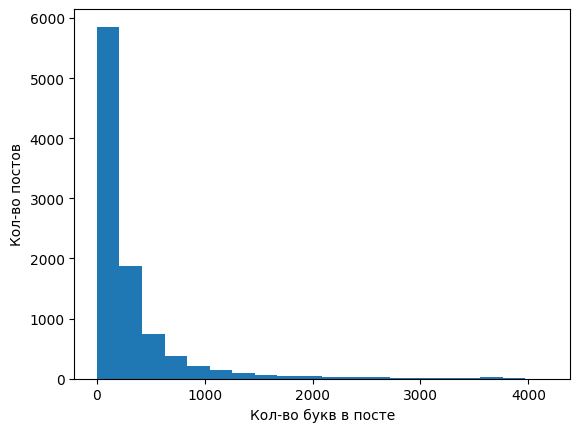

In [67]:
text_lenths = data['text_preprocessed'].str.len()

plt.hist(text_lenths, bins=20)
plt.xlabel('Кол-во букв в посте')
plt.ylabel('Кол-во постов')
plt.show()

In [68]:
data = data.loc[(data['text_preprocessed'].str.len() >= 100) & (data['text_preprocessed'].str.len() <= 1000)]
data = data.reset_index(drop=True)
data.shape

(5310, 2)

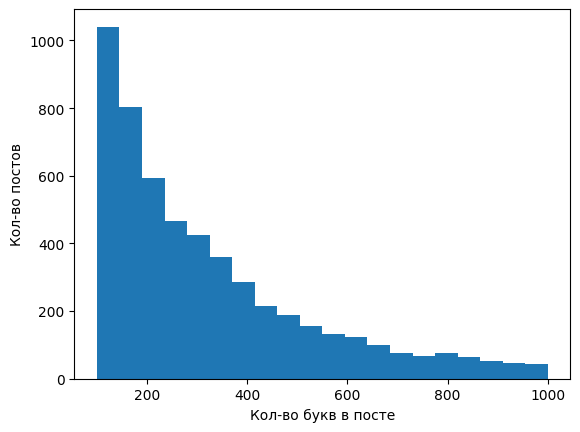

In [69]:
text_lenths = data['text_preprocessed'].str.len()

plt.hist(text_lenths, bins=20)
plt.xlabel('Кол-во букв в посте')
plt.ylabel('Кол-во постов')
plt.show()

In [70]:
data.head()

,text_preprocessed,label
0,зато совершаем по итогам вчерашнего дня самую ...,buy
1,вот сегодня отчитались и . .. из-за демпфера б...,sell
2,"представляете, что будет с рынком рф если сво ...",sell
3,на этой неделе можно было сделать месячную при...,buy
4,совет директоров башнефти рекомендовал выплати...,buy


In [71]:
(data.head()['text_preprocessed'][2])

'представляете, что будет с рынком рф если сво кончится нефтянка на избыточных доходах от нефти улетит вверх на таком позитиве, риски уйдут новых мобилизаций и т.д. потенциальных чёрных лебедей меньше станет, рынок рф на свои хаи и выше полетит, золотодобытчики на шорт сквизах полетят в небеса за золотом.'

In [72]:
data['label'].value_counts()

label
neutral    2034
buy        1767
sell       1509
Name: count, dtype: int64

Проведена предобработка текстов, распределение классов почти равномерное.

### **Fine-tuning & Validation**

Возьмем rubert-base-cased, заморозим слои, наденем классификационную голову и её затюним :)

In [86]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_gui
import time

tqdm.pandas(bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

In [79]:
class BERTWithMLP(nn.Module):
    def __init__(self, bert_model_name, num_labels=3, hidden_size=768, dropout_prob=0.1):
        super().__init__()
        # Загружаем BERT без головы
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Замораживаем все слои BERT
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Наша MLP голова
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

In [80]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {'buy': 0, 'sell': 1, 'neutral': 2}
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.label_map[self.labels[idx]]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [81]:
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BERTWithMLP(model_name, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
# Разделение данных для обучения
train_df, val_df = train_test_split(data, test_size=0.1, random_state=42)

In [83]:
train_dataset = FinancialDataset(
    train_df['text_preprocessed'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = FinancialDataset(
    val_df['text_preprocessed'].values,
    val_df['label'].values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [85]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# Инициализация для логирования
train_loss_history = []  # Лосс на каждом батче трейна
val_loss_history = []    # Лосс на каждом батче валидации
epoch_train_loss = []    # Средний лосс по эпохам (тренировка)
epoch_val_loss = []      # Средний лосс по эпохам (валидация)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_train_loss = []
    
    train_iterator = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{epochs} [TRAIN]', 
                         bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                         colour='green')
    
    for batch in train_iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_train_loss.append(loss.item())
        train_iterator.set_postfix({'batch_loss': f'{loss.item():.4f}'})

    train_loss_history.extend(batch_train_loss)
    epoch_train_loss.append(total_loss/len(train_loader))
    
    with tqdm.external_write_mode():
        tqdm.write(f"\nEpoch {epoch+1} Summary:")
        tqdm.write(f"Train Loss: {epoch_train_loss[-1]:.4f}")
    
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    batch_val_loss = []
    
    val_iterator = tqdm(val_loader, 
                       desc=f'Epoch {epoch+1}/{epochs} [VAL]', 
                       bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                       colour='blue')
    
    with torch.no_grad():
        for batch in val_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            batch_val_loss.append(loss.item())
            
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_iterator.set_postfix({'batch_acc': f'{(predicted == labels).float().mean().item():.2f}'})
    
    val_loss_history.extend(batch_val_loss)
    epoch_val_loss.append(val_loss/len(val_loader))
    
    with tqdm.external_write_mode():
        tqdm.write(f"Val Loss: {epoch_val_loss[-1]:.4f}")
        tqdm.write(f"Val Accuracy: {correct/total:.4f}\n")
    
    time.sleep(0.5)

In [ ]:
# Визуализация после обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train', alpha=0.7)
plt.plot(np.linspace(0, len(train_loss_history)-1, len(val_loss_history)), 
         val_loss_history, label='Val', alpha=0.7)
plt.title('Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Train', marker='o')
plt.plot(epoch_val_loss, label='Val', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод финальных метрик
# print(f"\nFinal Metrics:")
# print(f"Train Loss: {epoch_train_loss[-1]:.4f}")
# print(f"Val Loss: {epoch_val_loss[-1]:.4f}")
# print(f"Val Accuracy: {correct/total:.4f}")

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'classifier_config': {
        'hidden_size': 768,
        'num_labels': 3,
        'dropout_prob': 0.1
    }
}, 'rubert_mlp.pth')

**Вектор для дальнейших экспериментов:**
- Взять rubert-base-cased, разморозить верхние слои + классификационную голову. Попробуем обучить часть модели и голову и посмотрим на результат.
- Взять другую модель, например, большой берт или Roberta. Сравнить результаты.

### **Tests**

In [ ]:
def load_model_for_test(model_path, bert_model_name):
    checkpoint = torch.load(model_path)
    model = BERTWithMLP(
        bert_model_name,
        num_labels=checkpoint['classifier_config']['num_labels'],
        hidden_size=checkpoint['classifier_config']['hidden_size'],
        dropout_prob=checkpoint['classifier_config']['dropout_prob']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def evaluate_on_test(test_df, model_path='rubert_mlp.pth'):
    model = load_model_for_test(model_path, model_name)
    model.to(device)
    model.eval()
    
    test_dataset = FinancialDataset(
        test_df['text_preprocessed'].values,
        test_df['label'].values,
        tokenizer
    )
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()
            
            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels)
    
    from sklearn.metrics import classification_report
    print(classification_report(true_labels, predictions, target_names=['buy', 'sell', 'neutral']))

Проверка качества на голдене

In [ ]:
evaluate_on_test(
    test_df=test_set,
    model_path='rubert_mlp.pth'
)